In [1]:
!pip install pystac-client stackstac geopandas numpy xarray matplotlib


In [19]:
# Iowa, USA lat and long for where there is lots of vegetation
lat, lon = 42.0325, -93.5815

In [26]:
import pystac_client

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"  # Sentinel-2 Level-2A collection

catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 0.1, lat - 0.1, lon + 0.1, lat + 0.1), 
    max_items=100,
    query={"eo:cloud_cover": {"lt": 20}},
)

all_items = search.get_all_items()

items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

Found 16 items


In [27]:
epsg = items[0].properties["proj:epsg"]

# Convert point of interest (in Iowa) into the image projection
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

# Create bounds
size = 128 
gsd = 3 
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

In [21]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Extract EPSG projection from the first item
epsg = all_items[0].properties["proj:epsg"]

# Convert Iowa's lat/lon to the coordinate system of the satellite data
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

size = 128
gsd = 10     # Ground sampling distance for Sentinel-2 (10m/pixel)

bounds = (
    coords[0] - (size * gsd) / 2,
    coords[1] - (size * gsd) / 2,
    coords[0] + (size * gsd) / 2,
    coords[1] + (size * gsd) / 2,
)


In [29]:
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="float64",
    rescale=False,
    fill_value=0,
    assets=["blue", "green", "red", "nir"],
    resampling=Resampling.nearest,
)

print(stack)

stack = stack.compute()

<xarray.DataArray 'stackstac-0920776306d9314447c4c9875e2a3952' (time: 16,
                                                                band: 4,
                                                                y: 128, x: 128)> Size: 8MB
dask.array<fetch_raster_window, shape=(16, 4, 128, 128), dtype=float64, chunksize=(1, 1, 128, 128), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 128B 2023-...
    id                                       (time) <U24 2kB 'S2A_15TVG_20230...
  * band                                     (band) <U5 80B 'blue' ... 'nir'
  * x                                        (x) float64 1kB 4.517e+05 ... 4....
  * y                                        (y) float64 1kB 4.654e+06 ... 4....
    s2:datatake_id                           (time) <U34 2kB 'GS2A_20230615T1...
    ...                                       ...
    proj:transform                           object 8B {0, 4700040, 10, -10, ...
   

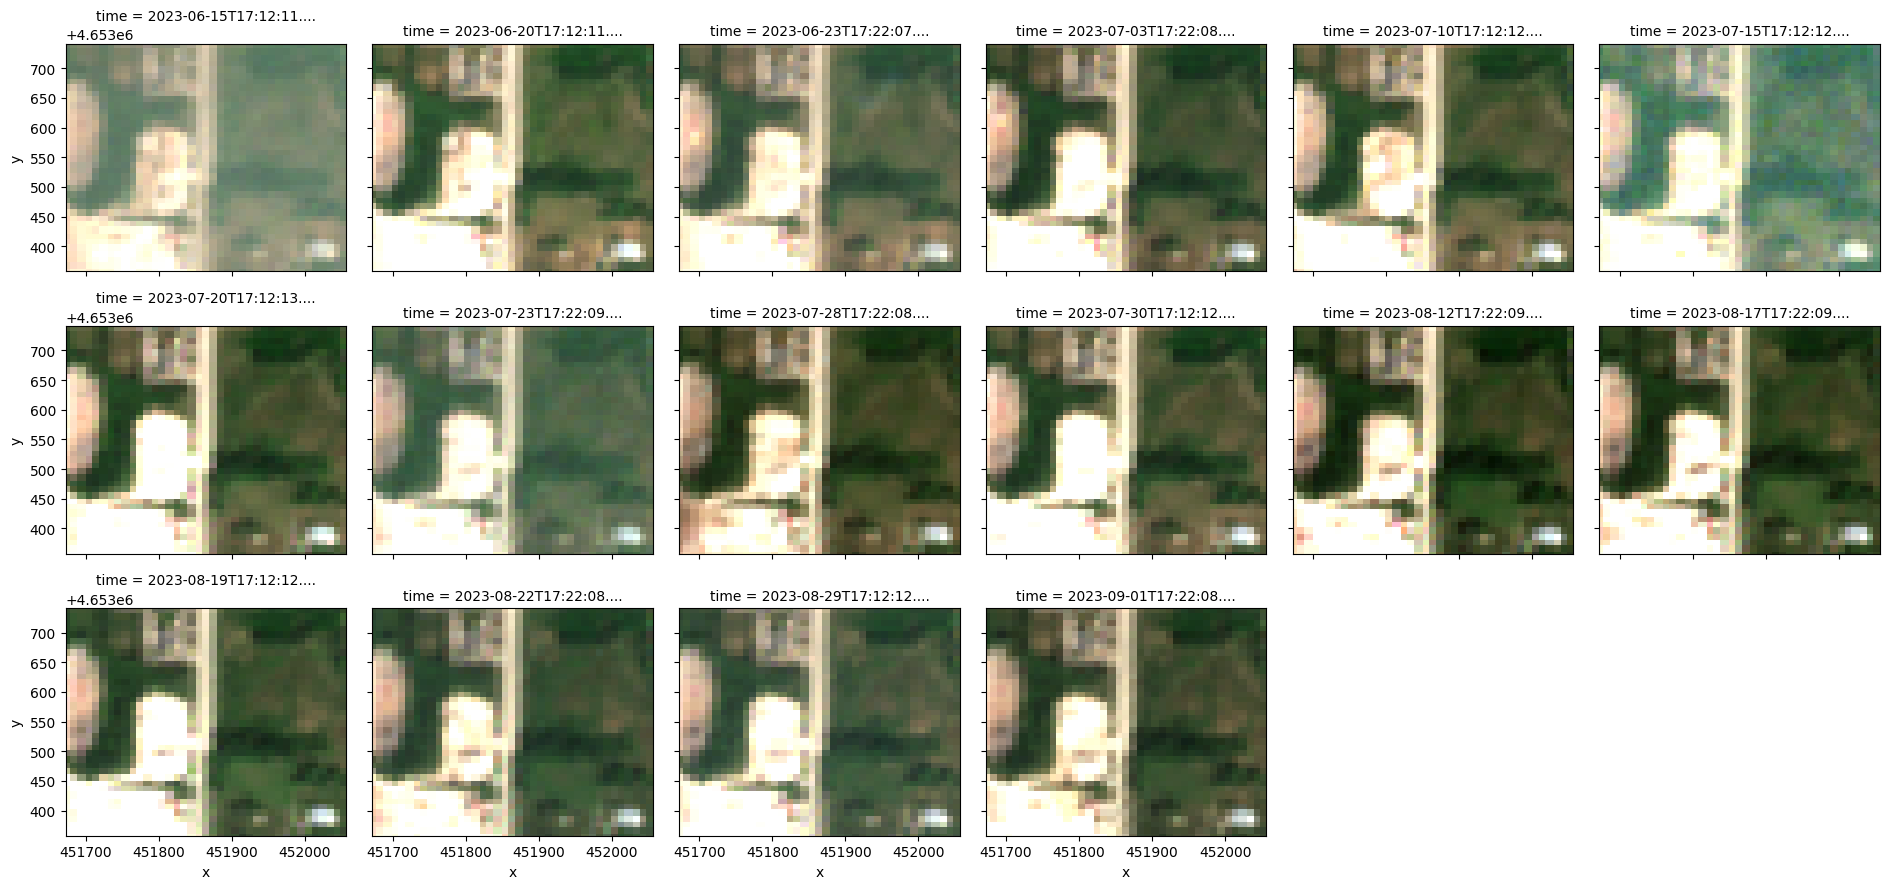

In [33]:
stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

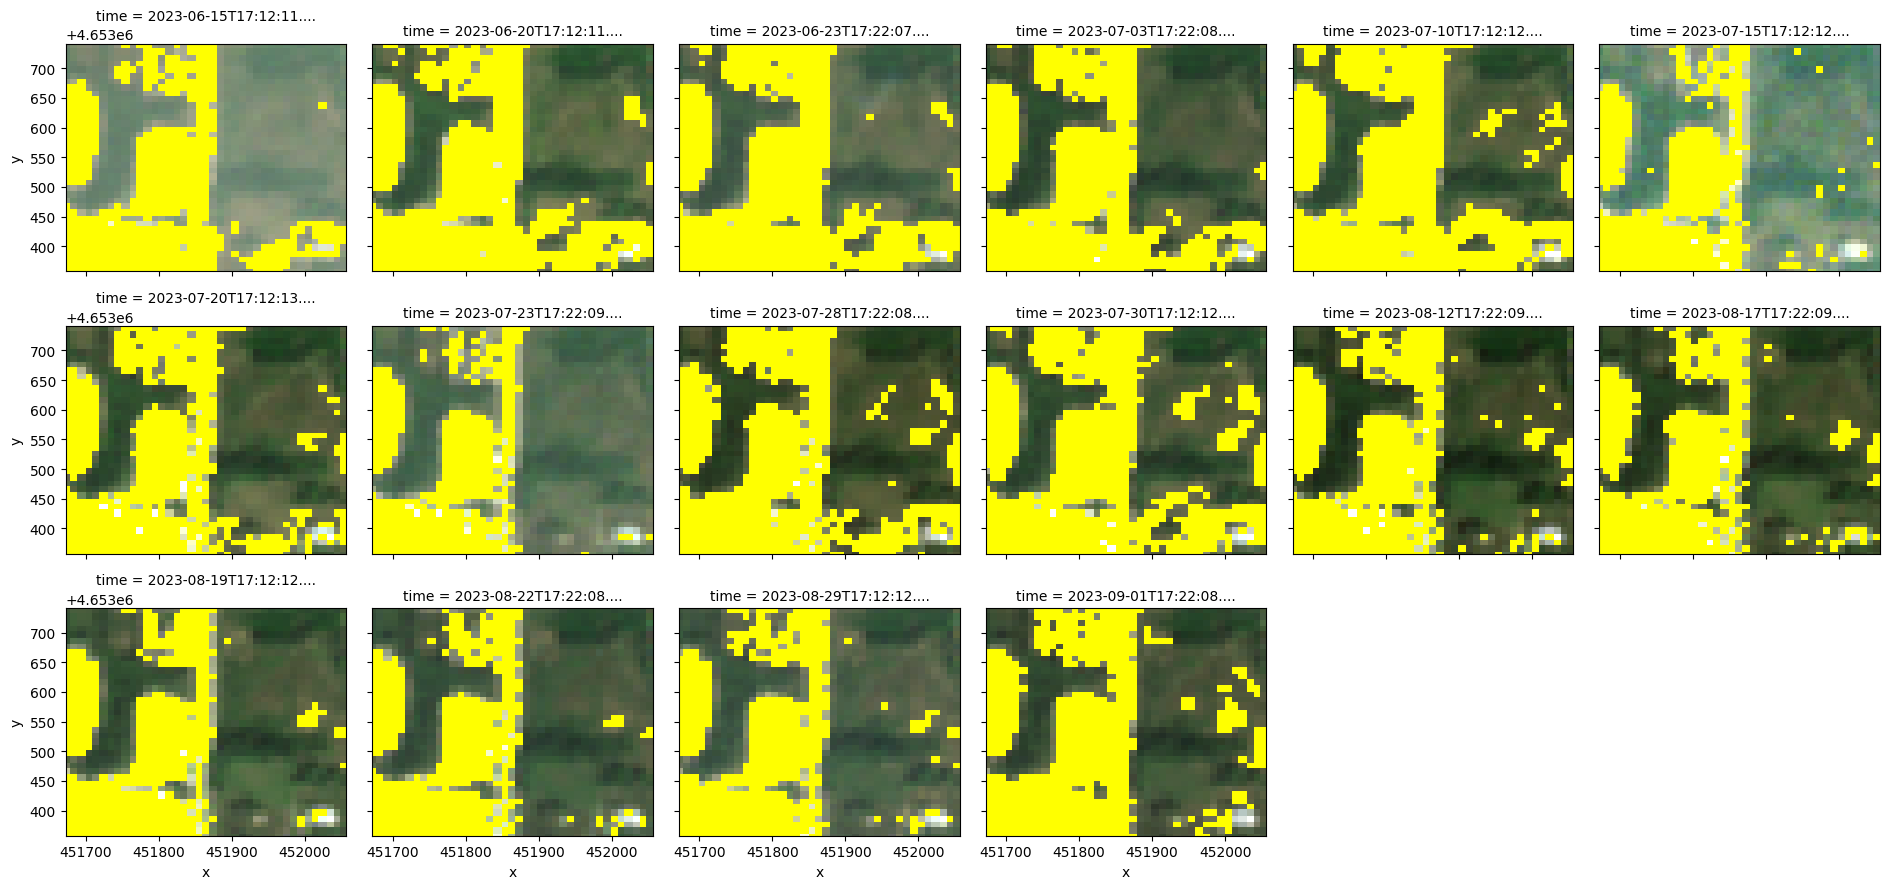

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

stack = stack.compute()

rgb_stack = stack.sel(band=["red", "green", "blue"])

rgb_array = rgb_stack.values 

highlighted_array = np.zeros_like(rgb_array)

for t in range(rgb_array.shape[0]):
    red, green, blue = rgb_array[t, 0, :, :], rgb_array[t, 1, :, :], rgb_array[t, 2, :, :]
    
    # Created a mask to identify green areas
    green_mask = (green > red) & (green > blue)
    
    highlighted_image = np.stack([
        np.where(green_mask, red, 2000),     
        np.where(green_mask, green, 2000),    
        np.where(green_mask, blue, 0)         
    ], axis=0)

    highlighted_array[t] = highlighted_image

highlighted_stack = xr.DataArray(
    highlighted_array,
    dims=("time", "band", "y", "x"),
    coords=rgb_stack.coords
)

highlighted_stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

plt.show()

In [22]:
from rasterio.enums import Resampling

# Adjust the stack creation line
stack = stackstac.stack(
    all_items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="float64",
    rescale=False,
    fill_value=0,
    assets=["B04", "B08"],  # B04: Red, B08: NIR for NDVI
    resampling=Resampling.nearest,  # Use Resampling from rasterio.enums
)

In [23]:
print(stack) 

<xarray.DataArray 'stackstac-442b4a6f874ff1497e33f24a164673a9' (time: 0,
                                                                band: 0,
                                                                y: 128, x: 128)> Size: 0B
dask.array<fetch_raster_window, shape=(0, 0, 128, 128), dtype=float64, chunksize=(0, 0, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 0B 
    id       (time) float64 0B 
  * band     (band) float64 0B 
  * x        (x) float64 1kB 4.512e+05 4.512e+05 ... 4.525e+05 4.525e+05
  * y        (y) float64 1kB 4.654e+06 4.654e+06 ... 4.653e+06 4.653e+06
    epsg     int64 8B 32615
Attributes:
    spec:        RasterSpec(epsg=32615, bounds=(451225.9790270366, 4652908.21...
    crs:         epsg:32615
    transform:   | 10.00, 0.00, 451225.98|\n| 0.00,-10.00, 4654188.22|\n| 0.0...
    resolution:  10


In [18]:
# Assuming the first band is Red and the second is NIR based on index inspection
red = stack.isel(band=0)  # Replace 0 with the correct index if different
nir = stack.isel(band=1)  # Replace 1 with the correct index if different

# Calculate NDVI
ndvi = (nir - red) / (nir + red)
print("NDVI calculation complete.")


IndexError: Index 0 is out of bounds for axis 1 with size 0